# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset,TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_tensor
from transformers import ViTFeatureExtractor, ViTForImageClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import datasets
from datasets import Dataset
import pandas as pd
import random
import math
from pathlib import Path

# Load the Dataset

In [2]:
# NIH CHEST X-RAY
image_folder_path = '/rds/projects/r/rajpookm-deep-learning/axs2098/nih_sample/images/'
# Load the metadata file
train_val_split = 0.2
dataset = datasets.load_dataset(
    "imagefolder",
    data_dir=image_folder_path,
)
# Split the dataset into train and validation sets
split = dataset["train"].train_test_split(train_val_split, seed=42)
train_dataset = split["train"]
test_dataset = split["test"]


Resolving data files:   0%|          | 0/5607 [00:00<?, ?it/s]

Found cached dataset imagefolder (/rds/homes/a/axs2098/.cache/huggingface/datasets/imagefolder/default-ded931f92d2a990b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /rds/homes/a/axs2098/.cache/huggingface/datasets/imagefolder/default-ded931f92d2a990b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-e8585ca10a9397f6.arrow and /rds/homes/a/axs2098/.cache/huggingface/datasets/imagefolder/default-ded931f92d2a990b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-f0018fb576b11f17.arrow


In [3]:
# Store the unique labels
unique_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
                 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening',
                 'Pneumonia', 'Pneumothorax']

# Convert one-hot encoded labels to class indices
labels = dataset['train']['labels']
label_data = np.array(labels)
# Calculate class counts
class_counts = np.sum(label_data, axis=0)

num_classes = len(labels[0])

# Print unique labels along with their corresponding sample counts
for label, count in zip(unique_labels, class_counts):
    print(f"{label}: {count} samples")

Atelectasis: 508.0 samples
Cardiomegaly: 141.0 samples
Consolidation: 226.0 samples
Edema: 118.0 samples
Effusion: 644.0 samples
Emphysema: 127.0 samples
Fibrosis: 84.0 samples
Hernia: 13.0 samples
Infiltration: 967.0 samples
Mass: 284.0 samples
No Finding: 3044.0 samples
Nodule: 313.0 samples
Pleural_Thickening: 176.0 samples
Pneumonia: 62.0 samples
Pneumothorax: 271.0 samples


In [9]:
len(split['test']['labels'])

1122

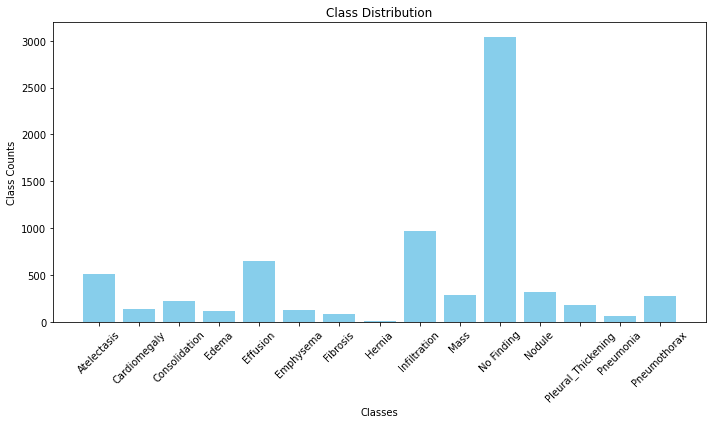

In [4]:
# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, class_counts, color='skyblue')

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Class Counts')
plt.title('Class Distribution')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Visualise the dataset

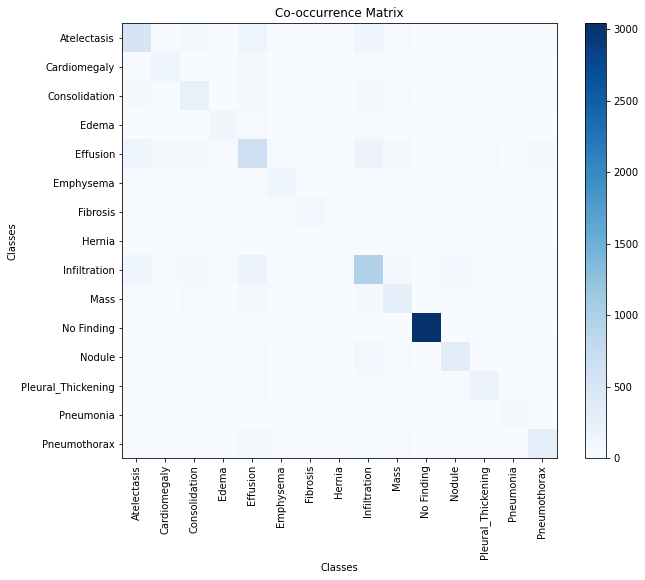

In [5]:
# Calculate the co-occurrence matrix
co_occurrence_matrix = np.dot(np.array(labels).T, np.array(labels))

# Plot the co-occurrence matrix
plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence_matrix, cmap='Blues', interpolation='nearest')
plt.title("Co-occurrence Matrix")
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.xticks(range(len(unique_labels)), unique_labels, rotation=90)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.colorbar()
plt.show()

### Remove minority labels and samples

In [5]:
# Determine classes with less than 50 samples
min_samples = 100
labels_to_drop = [idx for idx, count in enumerate(class_counts) if count < min_samples]

total_length = len(labels[0])
minority_classes = [0 if idx in labels_to_drop else 1 for idx in range(total_length)]

# Print the new list
print(minority_classes)

# Select only few 'No Finding' samples
# Find the label index with the most samples (11th label)
no_finding_index = 10  # Index corresponding to the 11th label
no_finding_samples = 500
no_finding = [idx for idx, label in enumerate(label_data) if label[no_finding_index] == 1]
no_finding_indices = random.sample(no_finding, no_finding_samples)

# Collect indices of label sets that don't have any of the minority classes
indices_without_nofinding = [idx for idx, label in enumerate(label_data) if label[no_finding_index] == 0]
# Get labels 
labels_without_nofinding = [label_data[idx] for idx in indices_without_nofinding]

majority_indices = []

for idx, label in enumerate(labels_without_nofinding):
    if not(label[6] == 1 or label[7] == 1 or label[13] == 1):
        majority_indices.append(idx)        
        
combined_indices = no_finding_indices + majority_indices
# Print the collected indices
print(len(majority_indices))

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
2404


In [34]:
majority_indices[2000]

4775

In [6]:
len(majority_indices)

2404

### Create a new dataset with only selected samples

In [7]:
selected_features = [dataset['train'][idx]['image'] for idx in combined_indices]
selected_labels = [dataset['train'][idx]['labels'] for idx in combined_indices]

# Create new tensors by dropping the specified column
updated_labels = [label[:6] + label[8:13] + label[14:] for label in selected_labels]

# Split the data into train and test sets
train_feat, test_feat, train_lab, test_lab = train_test_split(
    selected_features, updated_labels, test_size=0.2, random_state=42
)

# Print the shapes of the train and test sets
print("Train features shape:", len(train_feat))
print("Train labels shape:", len(train_lab))
print("Test features shape:", len(test_feat))
print("Test labels shape:", len(test_lab))

Train features shape: 2323
Train labels shape: 2323
Test features shape: 581
Test labels shape: 581


In [8]:
train_dataset = Dataset.from_dict({
    "image": train_feat,
    "labels": train_lab
    })
test_dataset = Dataset.from_dict({
    "image": test_feat,
    "labels": test_lab
    })

# Image Preprocessing for ViT

### Define the feature extractor

In [9]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/rds/homes/a/axs2098/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
# Feature extraction for train dataset

train_features = []
train_labels = []
for example in train_dataset:
    image = example["image"]
    image = image.convert("RGB")
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    train_features.append(features)
    train_labels.append(example["labels"])


train_features = torch.cat(train_features, dim=0)
train_labels = torch.tensor(train_labels)

In [11]:
# Feature extraction for the test dataset
test_features = []
test_labels = []
for example in test_dataset:
    image = example["image"]
    image = image.convert("RGB")
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    test_features.append(features)
    test_labels.append(example["labels"])

test_features = torch.cat(test_features, dim=0)
test_labels = torch.tensor(test_labels)

In [11]:
len(test_labels)

581

# Data Augmentation

## MLSMOTE

### Minority or Tail label selection

In [15]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    '''
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    '''
    index = get_index(y)
    X_sub = [X[i] for i in index]
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub



### Augmenting Data (using SMOTE)

In [21]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    '''
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    '''
    index = get_index(y)
    X_sub = [X[i] for i in index]
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub


In [22]:
# Convert train_y tensor to DataFrame with separate columns for each class
train_y_list = train_labels.numpy().tolist()
num_classes = len(train_y_list[0])  # Assuming train_y is a list of labels for each image
train_y_df = pd.DataFrame(train_y_list, columns=[f'label_{i}' for i in range(num_classes)])

# Print the first few rows of the DataFrames
print(train_y_df.head())

   label_0  label_1  label_2  label_3  label_4  label_5  label_6  label_7  \
0      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

   label_8  label_9  label_10  label_11  label_12  label_13  label_14  
0      0.0      0.0       0.0       1.0       0.0       0.0       0.0  
1      1.0      0.0       0.0       0.0       0.0       0.0       0.0  
2      0.0      0.0       1.0       0.0       0.0       0.0       0.0  
3      0.0      0.0       1.0       0.0       0.0       0.0       0.0  
4      1.0      0.0       0.0       0.0       0.0       0.0       0.0  


In [24]:
X_sub, y_sub = get_minority_instace(train_dataset['image'], train_y_df) 

In [15]:
# Assuming train_y_df is your DataFrame with separate columns for each class
train_y_tensor = torch.tensor(y_sub.values, dtype=torch.float32)  # Assuming your labels are floats

print(train_y_tensor[0])


tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [16]:
len

<function len(obj, /)>

In [17]:
train_aug_dataset = Dataset.from_dict({
    "image": X_sub,
    "labels": train_y_tensor
    })

In [18]:
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1024x1024 at 0x7FE1E4880E90>,
 'labels': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [19]:
from torchvision.transforms import ToTensor, Normalize, Grayscale

# Define data augmentation transforms
data_augmentation = transforms.Compose([
    #Grayscale(num_output_channels=3),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    ToTensor(),
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Extract features from the dataset with data augmentation
train_features_aug = []
train_labels_aug = []
for example in train_aug_dataset:
    image = example["image"]
    image = image.convert("RGB")
    image = data_augmentation(image)
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    train_features_aug.append(features)
    train_labels_aug.append(example["labels"])

train_features_aug = torch.cat(train_features_aug, dim=0)
train_labels_aug = torch.tensor(train_labels_aug)


In [20]:
len(train_labels_aug)

261

In [21]:
train_features_combined = torch.cat((train_features, train_features_aug), dim=0)
train_labels_combined = torch.cat((train_labels, train_labels_aug), dim=0)

In [59]:
len(train_labels_combined)

2584

# Fine-tuning ViT on NIH

## Fine-tuning on original NIH

In [ ]:
train_features = torch.load(root_path+"features/train_features.pt")
train_labels = torch.load(root_path+"features/train_labels.pt")

test_features = torch.load(root_path+"features/test_features.pt")
test_labels = torch.load(root_path+"features/test_labels.pt")

### Define the model and the hyperparameters

In [16]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = len(train_labels[0])
LEARNING_RATE = 1e-4

# Initialize the ViT model for image classification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
# Load pretrained ViT model

# Modify the output layer for multilabel classification with 15 classes
model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)

# Define loss function and optimizer
# Binary Cross-Entropy Loss for multilabel classification
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Move the model and data to GPU if available
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [14]:
# Create DataLoader for training

train_dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [18]:
# Train the model
num_epochs = NUM_EPOCHS
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Initialize the ViT model for image classification
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
    # Load pretrained ViT model

    # Modify the output layer for multilabel classification with 15 classes
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(testlosses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

Epoch 1/10, Train Loss: 0.2465, Test Loss: 0.3299
Test Loss: 0.3299, Test Accuracy: 0.1343, Test AUC ROC: 0.6422, F1-Score : 0.1912
Epoch 2/10, Train Loss: 0.2073, Test Loss: 0.3378
Test Loss: 0.3378, Test Accuracy: 0.1119, Test AUC ROC: 0.6664, F1-Score : 0.1886
Epoch 3/10, Train Loss: 0.1768, Test Loss: 0.3555
Test Loss: 0.3555, Test Accuracy: 0.1274, Test AUC ROC: 0.6677, F1-Score : 0.2580
Epoch 4/10, Train Loss: 0.1443, Test Loss: 0.3609
Test Loss: 0.3609, Test Accuracy: 0.1532, Test AUC ROC: 0.6827, F1-Score : 0.2766
Epoch 5/10, Train Loss: 0.1141, Test Loss: 0.3873
Test Loss: 0.3873, Test Accuracy: 0.1446, Test AUC ROC: 0.6708, F1-Score : 0.2517
Epoch 6/10, Train Loss: 0.0902, Test Loss: 0.4041
Test Loss: 0.4041, Test Accuracy: 0.1532, Test AUC ROC: 0.6649, F1-Score : 0.3109
Epoch 7/10, Train Loss: 0.0644, Test Loss: 0.4291
Test Loss: 0.4291, Test Accuracy: 0.1153, Test AUC ROC: 0.6655, F1-Score : 0.2286
Epoch 8/10, Train Loss: 0.0465, Test Loss: 0.4477
Test Loss: 0.4477, Test Ac

In [18]:
# Save the fine-tuned model
output_dir = './final_model_nih_original'
model.save_pretrained(output_dir)

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [19]:
test_precision = precision_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
test_recall = recall_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.6513545347467609
0.39755571531272466


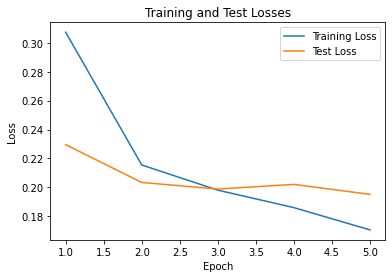

## Fine-tuning on NIH DA

In [ ]:
train_features = torch.load(root_path+"features/train_features_DA.pt")
train_labels = torch.load(root_path+"features/train_labels_DA.pt")

test_features = torch.load(root_path+"features/test_features.pt")
test_labels = torch.load(root_path+"features/test_labels.pt")

### Define the model and the hyperparameters

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = len(train_labels[0])
LEARNING_RATE = 1e-4

# Initialize the ViT model for image classification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
# Load pretrained ViT model

# Modify the output layer for multilabel classification with 15 classes
model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)

# Define loss function and optimizer
# Binary Cross-Entropy Loss for multilabel classification
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Move the model and data to GPU if available
model.to(device)

In [ ]:
# Create DataLoader for training
train_features_combined = train_features_combined.to(device)
train_labels_combined = train_labels_combined.to(device)

train_dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [ ]:
# Train the model
num_epochs = NUM_EPOCHS
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Initialize the ViT model for image classification
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
    # Load pretrained ViT model

    # Modify the output layer for multilabel classification with 15 classes
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(testlosses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

## Fine-tuning on NIH class balanced

### Define the model and the hyperparameters

In [12]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = len(train_labels[0])
LEARNING_RATE = 1e-4

# Initialize the ViT model for image classification
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
# Load pretrained ViT model

# Modify the output layer for multilabel classification with 15 classes
model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)

# Define loss function and optimizer
# Binary Cross-Entropy Loss for multilabel classification
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Move the model and data to GPU if available
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
# Create DataLoader for training
train_dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [14]:
# Train the model
num_epochs = NUM_EPOCHS
batch_size = BATCH_SIZE

# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Initialize the ViT model for image classification
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
    # Load pretrained ViT model

    # Modify the output layer for multilabel classification with 15 classes
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 1
Epoch 1/5, Train Loss: 0.3489, Test Loss: 0.2636
Test Loss: 0.2636, Test Accuracy: 0.6575, Test AUC ROC: 0.5638, F1-Score: 0.6146
Epoch 2/5, Train Loss: 0.2455, Test Loss: 0.2176
Test Loss: 0.2176, Test Accuracy: 0.6299, Test AUC ROC: 0.5306, F1-Score: 0.6124
Epoch 3/5, Train Loss: 0.2172, Test Loss: 0.2052
Test Loss: 0.2052, Test Accuracy: 0.6506, Test AUC ROC: 0.5439, F1-Score: 0.6182
Epoch 4/5, Train Loss: 0.2001, Test Loss: 0.1982
Test Loss: 0.1982, Test Accuracy: 0.4785, Test AUC ROC: 0.7086, F1-Score: 0.5435
Epoch 5/5, Train Loss: 0.1812, Test Loss: 0.2047
Test Loss: 0.2047, Test Accuracy: 0.4802, Test AUC ROC: 0.6914, F1-Score: 0.5427


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 2
Epoch 1/5, Train Loss: 0.3479, Test Loss: 0.2624
Test Loss: 0.2624, Test Accuracy: 0.6592, Test AUC ROC: 0.5319, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2447, Test Loss: 0.2227
Test Loss: 0.2227, Test Accuracy: 0.4441, Test AUC ROC: 0.6918, F1-Score: 0.5198
Epoch 3/5, Train Loss: 0.2173, Test Loss: 0.2162
Test Loss: 0.2162, Test Accuracy: 0.3494, Test AUC ROC: 0.7068, F1-Score: 0.4410
Epoch 4/5, Train Loss: 0.2024, Test Loss: 0.1979
Test Loss: 0.1979, Test Accuracy: 0.5198, Test AUC ROC: 0.6685, F1-Score: 0.5652
Epoch 5/5, Train Loss: 0.1839, Test Loss: 0.1978
Test Loss: 0.1978, Test Accuracy: 0.5370, Test AUC ROC: 0.6671, F1-Score: 0.5720


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 3
Epoch 1/5, Train Loss: 0.3579, Test Loss: 0.2677
Test Loss: 0.2677, Test Accuracy: 0.6575, Test AUC ROC: 0.5029, F1-Score: 0.6141
Epoch 2/5, Train Loss: 0.2473, Test Loss: 0.2191
Test Loss: 0.2191, Test Accuracy: 0.5439, Test AUC ROC: 0.6273, F1-Score: 0.5738
Epoch 3/5, Train Loss: 0.2158, Test Loss: 0.2043
Test Loss: 0.2043, Test Accuracy: 0.5663, Test AUC ROC: 0.5919, F1-Score: 0.5883
Epoch 4/5, Train Loss: 0.1982, Test Loss: 0.1981
Test Loss: 0.1981, Test Accuracy: 0.5783, Test AUC ROC: 0.6358, F1-Score: 0.5950
Epoch 5/5, Train Loss: 0.1758, Test Loss: 0.2019
Test Loss: 0.2019, Test Accuracy: 0.5800, Test AUC ROC: 0.6191, F1-Score: 0.5905


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 4
Epoch 1/5, Train Loss: 0.3459, Test Loss: 0.2612
Test Loss: 0.2612, Test Accuracy: 0.6592, Test AUC ROC: 0.6154, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2430, Test Loss: 0.2156
Test Loss: 0.2156, Test Accuracy: 0.6248, Test AUC ROC: 0.5535, F1-Score: 0.6089
Epoch 3/5, Train Loss: 0.2153, Test Loss: 0.2022
Test Loss: 0.2022, Test Accuracy: 0.6179, Test AUC ROC: 0.5873, F1-Score: 0.6120
Epoch 4/5, Train Loss: 0.1977, Test Loss: 0.2121
Test Loss: 0.2121, Test Accuracy: 0.4286, Test AUC ROC: 0.6958, F1-Score: 0.5030
Epoch 5/5, Train Loss: 0.1803, Test Loss: 0.2153
Test Loss: 0.2153, Test Accuracy: 0.3494, Test AUC ROC: 0.7161, F1-Score: 0.4502


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 5
Epoch 1/5, Train Loss: 0.3476, Test Loss: 0.2636
Test Loss: 0.2636, Test Accuracy: 0.6592, Test AUC ROC: 0.5678, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2445, Test Loss: 0.2214
Test Loss: 0.2214, Test Accuracy: 0.4613, Test AUC ROC: 0.6785, F1-Score: 0.5327
Epoch 3/5, Train Loss: 0.2158, Test Loss: 0.2031
Test Loss: 0.2031, Test Accuracy: 0.5439, Test AUC ROC: 0.6326, F1-Score: 0.5759
Epoch 4/5, Train Loss: 0.1959, Test Loss: 0.2018
Test Loss: 0.2018, Test Accuracy: 0.4923, Test AUC ROC: 0.6961, F1-Score: 0.5509
Epoch 5/5, Train Loss: 0.1767, Test Loss: 0.2011
Test Loss: 0.2011, Test Accuracy: 0.4923, Test AUC ROC: 0.7118, F1-Score: 0.5460


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 6
Epoch 1/5, Train Loss: 0.3418, Test Loss: 0.2587
Test Loss: 0.2587, Test Accuracy: 0.6592, Test AUC ROC: 0.5673, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2436, Test Loss: 0.2171
Test Loss: 0.2171, Test Accuracy: 0.6317, Test AUC ROC: 0.5956, F1-Score: 0.6065
Epoch 3/5, Train Loss: 0.2158, Test Loss: 0.2036
Test Loss: 0.2036, Test Accuracy: 0.5181, Test AUC ROC: 0.6266, F1-Score: 0.5597
Epoch 4/5, Train Loss: 0.2000, Test Loss: 0.2051
Test Loss: 0.2051, Test Accuracy: 0.4458, Test AUC ROC: 0.6977, F1-Score: 0.5198
Epoch 5/5, Train Loss: 0.1826, Test Loss: 0.1953
Test Loss: 0.1953, Test Accuracy: 0.5852, Test AUC ROC: 0.6520, F1-Score: 0.5995


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 7
Epoch 1/5, Train Loss: 0.3408, Test Loss: 0.2585
Test Loss: 0.2585, Test Accuracy: 0.6592, Test AUC ROC: 0.5159, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2433, Test Loss: 0.2156
Test Loss: 0.2156, Test Accuracy: 0.5594, Test AUC ROC: 0.5913, F1-Score: 0.5833
Epoch 3/5, Train Loss: 0.2171, Test Loss: 0.2017
Test Loss: 0.2017, Test Accuracy: 0.5628, Test AUC ROC: 0.6092, F1-Score: 0.5858
Epoch 4/5, Train Loss: 0.1995, Test Loss: 0.1993
Test Loss: 0.1993, Test Accuracy: 0.5060, Test AUC ROC: 0.6587, F1-Score: 0.5530
Epoch 5/5, Train Loss: 0.1813, Test Loss: 0.2031
Test Loss: 0.2031, Test Accuracy: 0.4458, Test AUC ROC: 0.7068, F1-Score: 0.5100


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 8
Epoch 1/5, Train Loss: 0.3432, Test Loss: 0.2583
Test Loss: 0.2583, Test Accuracy: 0.6592, Test AUC ROC: 0.5040, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2427, Test Loss: 0.2159
Test Loss: 0.2159, Test Accuracy: 0.6041, Test AUC ROC: 0.5972, F1-Score: 0.6040
Epoch 3/5, Train Loss: 0.2154, Test Loss: 0.2028
Test Loss: 0.2028, Test Accuracy: 0.5284, Test AUC ROC: 0.6503, F1-Score: 0.5667
Epoch 4/5, Train Loss: 0.1972, Test Loss: 0.2036
Test Loss: 0.2036, Test Accuracy: 0.6420, Test AUC ROC: 0.5755, F1-Score: 0.6140
Epoch 5/5, Train Loss: 0.1760, Test Loss: 0.2041
Test Loss: 0.2041, Test Accuracy: 0.4888, Test AUC ROC: 0.7038, F1-Score: 0.5502


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 9
Epoch 1/5, Train Loss: 0.3508, Test Loss: 0.2620
Test Loss: 0.2620, Test Accuracy: 0.6592, Test AUC ROC: 0.5694, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2450, Test Loss: 0.2164
Test Loss: 0.2164, Test Accuracy: 0.6231, Test AUC ROC: 0.5745, F1-Score: 0.6124
Epoch 3/5, Train Loss: 0.2179, Test Loss: 0.2014
Test Loss: 0.2014, Test Accuracy: 0.5731, Test AUC ROC: 0.6464, F1-Score: 0.5950
Epoch 4/5, Train Loss: 0.2025, Test Loss: 0.2040
Test Loss: 0.2040, Test Accuracy: 0.5129, Test AUC ROC: 0.6334, F1-Score: 0.5659
Epoch 5/5, Train Loss: 0.1853, Test Loss: 0.1962
Test Loss: 0.1962, Test Accuracy: 0.5645, Test AUC ROC: 0.6887, F1-Score: 0.5842


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 10
Epoch 1/5, Train Loss: 0.3417, Test Loss: 0.2591
Test Loss: 0.2591, Test Accuracy: 0.6592, Test AUC ROC: 0.5394, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2428, Test Loss: 0.2178
Test Loss: 0.2178, Test Accuracy: 0.6420, Test AUC ROC: 0.5100, F1-Score: 0.6115
Epoch 3/5, Train Loss: 0.2177, Test Loss: 0.2029
Test Loss: 0.2029, Test Accuracy: 0.5818, Test AUC ROC: 0.6078, F1-Score: 0.5991
Epoch 4/5, Train Loss: 0.2012, Test Loss: 0.1973
Test Loss: 0.1973, Test Accuracy: 0.5731, Test AUC ROC: 0.6571, F1-Score: 0.5944
Epoch 5/5, Train Loss: 0.1822, Test Loss: 0.1988
Test Loss: 0.1988, Test Accuracy: 0.5594, Test AUC ROC: 0.6278, F1-Score: 0.5798
Average Train Loss: 0.2375 ± 0.0585
Average Test Loss: 0.2175 ± 0.0232
Average Accuracy: 0.5083 ± 0.0695
Average F1-Score: 0.5525 ± 0.0427
Average AUC ROC: 0.6785 ± 0.0334


In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [40]:
# Save the fine-tuned model
output_dir = './final_model_nih_sel'
model.save_pretrained(output_dir)

In [41]:
test_precision = precision_score(true_labels, predicted_labels_binary, average='micro')
test_recall = recall_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.7240663900414938
0.5256024096385542


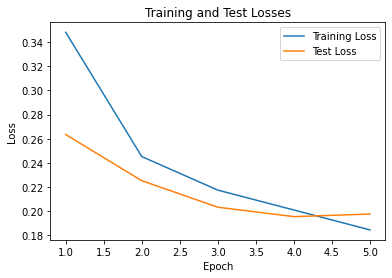

In [42]:
# Plot the training and test losses
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

# Fine-tuning on ViT fine-tune on dataverse

## Initialize the model

In [12]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = len(train_labels[0])
LEARNING_RATE = 1e-4

# Load pretrained ViT model
vit_dir = '/rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/'
model = ViTForImageClassification.from_pretrained(vit_dir, ignore_mismatched_sizes=True)

# Modify the output layer for multilabel classification
model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)

# Define loss function and optimizer
# Binary Cross-Entropy Loss for multilabel classification
#loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Move the model and data to GPU if available
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
# Create DataLoader for training
train_dataset = TensorDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
NUM_EPOCHS = 5

## Training Loop

In [16]:
# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Load pretrained ViT model
    vit_dir = '/rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/'
    model = ViTForImageClassification.from_pretrained(vit_dir, ignore_mismatched_sizes=True)

    # Modify the output layer for multilabel classification
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Move the model and data to GPU if available
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(test_losses)
    average_accuracies.append(accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 1
Epoch 1/5, Train Loss: 0.3564, Test Loss: 0.2532
Test Loss: 0.2532, Test Accuracy: 0.6592, Test AUC ROC: 0.5145, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2418, Test Loss: 0.2187
Test Loss: 0.2187, Test Accuracy: 0.6592, Test AUC ROC: 0.5299, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2246, Test Loss: 0.2099
Test Loss: 0.2099, Test Accuracy: 0.6592, Test AUC ROC: 0.5479, F1-Score: 0.6153
Epoch 4/5, Train Loss: 0.2188, Test Loss: 0.2066
Test Loss: 0.2066, Test Accuracy: 0.6523, Test AUC ROC: 0.5839, F1-Score: 0.6138
Epoch 5/5, Train Loss: 0.2122, Test Loss: 0.1971
Test Loss: 0.1971, Test Accuracy: 0.5663, Test AUC ROC: 0.6476, F1-Score: 0.5958


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 2
Epoch 1/5, Train Loss: 0.3659, Test Loss: 0.2523
Test Loss: 0.2523, Test Accuracy: 0.6592, Test AUC ROC: 0.5298, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2396, Test Loss: 0.2154
Test Loss: 0.2154, Test Accuracy: 0.6196, Test AUC ROC: 0.5715, F1-Score: 0.6049
Epoch 3/5, Train Loss: 0.2166, Test Loss: 0.2025
Test Loss: 0.2025, Test Accuracy: 0.6196, Test AUC ROC: 0.5524, F1-Score: 0.6117
Epoch 4/5, Train Loss: 0.1992, Test Loss: 0.2037
Test Loss: 0.2037, Test Accuracy: 0.4441, Test AUC ROC: 0.6983, F1-Score: 0.5219
Epoch 5/5, Train Loss: 0.1816, Test Loss: 0.2027
Test Loss: 0.2027, Test Accuracy: 0.5009, Test AUC ROC: 0.6646, F1-Score: 0.5561


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 3
Epoch 1/5, Train Loss: 0.3539, Test Loss: 0.2516
Test Loss: 0.2516, Test Accuracy: 0.6592, Test AUC ROC: 0.5190, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2407, Test Loss: 0.2175
Test Loss: 0.2175, Test Accuracy: 0.6592, Test AUC ROC: 0.4901, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2226, Test Loss: 0.2071
Test Loss: 0.2071, Test Accuracy: 0.6558, Test AUC ROC: 0.5348, F1-Score: 0.6135
Epoch 4/5, Train Loss: 0.2148, Test Loss: 0.2015
Test Loss: 0.2015, Test Accuracy: 0.5456, Test AUC ROC: 0.6591, F1-Score: 0.5846
Epoch 5/5, Train Loss: 0.2019, Test Loss: 0.1963
Test Loss: 0.1963, Test Accuracy: 0.5508, Test AUC ROC: 0.6344, F1-Score: 0.5845


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 4
Epoch 1/5, Train Loss: 0.3585, Test Loss: 0.2497
Test Loss: 0.2497, Test Accuracy: 0.6592, Test AUC ROC: 0.5244, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2411, Test Loss: 0.2179
Test Loss: 0.2179, Test Accuracy: 0.6592, Test AUC ROC: 0.5360, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2244, Test Loss: 0.2100
Test Loss: 0.2100, Test Accuracy: 0.6420, Test AUC ROC: 0.5296, F1-Score: 0.6080
Epoch 4/5, Train Loss: 0.2163, Test Loss: 0.1999
Test Loss: 0.1999, Test Accuracy: 0.5990, Test AUC ROC: 0.6117, F1-Score: 0.6066
Epoch 5/5, Train Loss: 0.2049, Test Loss: 0.1996
Test Loss: 0.1996, Test Accuracy: 0.4888, Test AUC ROC: 0.6958, F1-Score: 0.5500


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 5
Epoch 1/5, Train Loss: 0.3538, Test Loss: 0.2511
Test Loss: 0.2511, Test Accuracy: 0.6592, Test AUC ROC: 0.5392, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2408, Test Loss: 0.2181
Test Loss: 0.2181, Test Accuracy: 0.6592, Test AUC ROC: 0.5005, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2235, Test Loss: 0.2061
Test Loss: 0.2061, Test Accuracy: 0.6162, Test AUC ROC: 0.5711, F1-Score: 0.6030
Epoch 4/5, Train Loss: 0.2101, Test Loss: 0.2236
Test Loss: 0.2236, Test Accuracy: 0.2633, Test AUC ROC: 0.6914, F1-Score: 0.3525
Epoch 5/5, Train Loss: 0.1995, Test Loss: 0.2039
Test Loss: 0.2039, Test Accuracy: 0.4406, Test AUC ROC: 0.6719, F1-Score: 0.5146


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 6
Epoch 1/5, Train Loss: 0.3656, Test Loss: 0.2577
Test Loss: 0.2577, Test Accuracy: 0.6592, Test AUC ROC: 0.5253, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2442, Test Loss: 0.2194
Test Loss: 0.2194, Test Accuracy: 0.6592, Test AUC ROC: 0.5319, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2253, Test Loss: 0.2114
Test Loss: 0.2114, Test Accuracy: 0.6592, Test AUC ROC: 0.5025, F1-Score: 0.6153
Epoch 4/5, Train Loss: 0.2192, Test Loss: 0.2063
Test Loss: 0.2063, Test Accuracy: 0.6575, Test AUC ROC: 0.5497, F1-Score: 0.6146
Epoch 5/5, Train Loss: 0.2105, Test Loss: 0.2015
Test Loss: 0.2015, Test Accuracy: 0.4750, Test AUC ROC: 0.6866, F1-Score: 0.5394


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 7
Epoch 1/5, Train Loss: 0.3509, Test Loss: 0.2499
Test Loss: 0.2499, Test Accuracy: 0.6592, Test AUC ROC: 0.5119, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2395, Test Loss: 0.2173
Test Loss: 0.2173, Test Accuracy: 0.6592, Test AUC ROC: 0.5456, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2240, Test Loss: 0.2116
Test Loss: 0.2116, Test Accuracy: 0.6093, Test AUC ROC: 0.5467, F1-Score: 0.5945
Epoch 4/5, Train Loss: 0.2182, Test Loss: 0.2046
Test Loss: 0.2046, Test Accuracy: 0.5938, Test AUC ROC: 0.5788, F1-Score: 0.5946
Epoch 5/5, Train Loss: 0.2095, Test Loss: 0.1967
Test Loss: 0.1967, Test Accuracy: 0.5577, Test AUC ROC: 0.6398, F1-Score: 0.5878


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 8
Epoch 1/5, Train Loss: 0.3535, Test Loss: 0.2485
Test Loss: 0.2485, Test Accuracy: 0.6592, Test AUC ROC: 0.5147, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2394, Test Loss: 0.2169
Test Loss: 0.2169, Test Accuracy: 0.6592, Test AUC ROC: 0.5143, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2213, Test Loss: 0.2059
Test Loss: 0.2059, Test Accuracy: 0.5525, Test AUC ROC: 0.5777, F1-Score: 0.5771
Epoch 4/5, Train Loss: 0.2098, Test Loss: 0.1977
Test Loss: 0.1977, Test Accuracy: 0.5473, Test AUC ROC: 0.6360, F1-Score: 0.5833
Epoch 5/5, Train Loss: 0.1969, Test Loss: 0.1983
Test Loss: 0.1983, Test Accuracy: 0.5491, Test AUC ROC: 0.6491, F1-Score: 0.5803


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 9
Epoch 1/5, Train Loss: 0.3596, Test Loss: 0.2523
Test Loss: 0.2523, Test Accuracy: 0.6592, Test AUC ROC: 0.5187, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2413, Test Loss: 0.2173
Test Loss: 0.2173, Test Accuracy: 0.6592, Test AUC ROC: 0.5247, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2215, Test Loss: 0.2060
Test Loss: 0.2060, Test Accuracy: 0.6368, Test AUC ROC: 0.5153, F1-Score: 0.6069
Epoch 4/5, Train Loss: 0.2106, Test Loss: 0.2005
Test Loss: 0.2005, Test Accuracy: 0.5749, Test AUC ROC: 0.6307, F1-Score: 0.5941
Epoch 5/5, Train Loss: 0.1978, Test Loss: 0.2031
Test Loss: 0.2031, Test Accuracy: 0.6145, Test AUC ROC: 0.5736, F1-Score: 0.6051


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /rds/projects/r/rajpookm-deep-learning/axs2098/Saved_tensors/ and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Run : 10
Epoch 1/5, Train Loss: 0.3585, Test Loss: 0.2530
Test Loss: 0.2530, Test Accuracy: 0.6592, Test AUC ROC: 0.5219, F1-Score: 0.6153
Epoch 2/5, Train Loss: 0.2421, Test Loss: 0.2187
Test Loss: 0.2187, Test Accuracy: 0.6592, Test AUC ROC: 0.5457, F1-Score: 0.6153
Epoch 3/5, Train Loss: 0.2238, Test Loss: 0.2071
Test Loss: 0.2071, Test Accuracy: 0.5697, Test AUC ROC: 0.6220, F1-Score: 0.5861
Epoch 4/5, Train Loss: 0.2099, Test Loss: 0.1973
Test Loss: 0.1973, Test Accuracy: 0.5697, Test AUC ROC: 0.6433, F1-Score: 0.5967
Epoch 5/5, Train Loss: 0.1945, Test Loss: 0.1980
Test Loss: 0.1980, Test Accuracy: 0.5353, Test AUC ROC: 0.6679, F1-Score: 0.5815
Average Train Loss: 0.2470 ± 0.0571
Average Test Loss: 0.2163 ± 0.0192
Average Accuracy: 0.5279 ± 0.0485
Average F1-Score: 0.5695 ± 0.0269
Average AUC ROC: 0.6531 ± 0.0325


In [34]:
# Save the fine-tuned model
model_dir = './final_model_ftd_sel'
model.save_pretrained(model_dir)

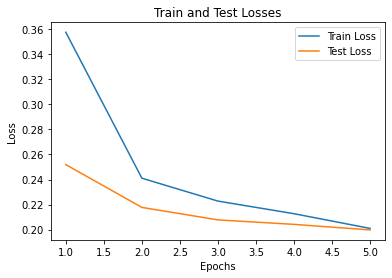

In [20]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()

# Display the plot
plt.show()

In [19]:
%matplotlib inline

In [35]:
from sklearn.metrics import precision_score, recall_score
test_precision = precision_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
test_recall = recall_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.7702020202020202
0.45933734939759036


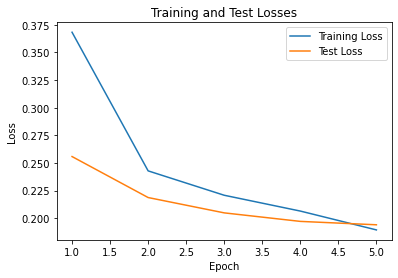

In [36]:
# Plot the training and test losses
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

# Fine-tuning (DA) on ViT fine-tuned on dataverse

In [ ]:
train_features_combined = train_features_combined.to(device)
train_labels_combined = train_labels_combined.to(device)
# Create DataLoader for training
train_dataset = TensorDataset(train_features_combined, train_labels_combined)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [24]:
# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Load pretrained ViT model
    vit_dir = './'
    model = ViTForImageClassification.from_pretrained(vit_dir, ignore_mismatched_sizes=True)

    # Modify the output layer for multilabel classification
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Move the model and data to GPU if available
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(testlosses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

Epoch 1/5, Train Loss: 0.3667, Test Loss: 0.2488
Test Loss: 0.2488, Test Accuracy: 0.6592, Test AUC ROC: 0.5340, F1-Score (Micro): 0.6153, F1-Score (Macro): 0.0662
Epoch 2/5, Train Loss: 0.2569, Test Loss: 0.2176
Test Loss: 0.2176, Test Accuracy: 0.6024, Test AUC ROC: 0.5515, F1-Score (Micro): 0.5939, F1-Score (Macro): 0.0651
Epoch 3/5, Train Loss: 0.2417, Test Loss: 0.2088
Test Loss: 0.2088, Test Accuracy: 0.5318, Test AUC ROC: 0.5998, F1-Score (Micro): 0.5675, F1-Score (Macro): 0.0639
Epoch 4/5, Train Loss: 0.2326, Test Loss: 0.1972
Test Loss: 0.1972, Test Accuracy: 0.5749, Test AUC ROC: 0.6195, F1-Score (Micro): 0.5989, F1-Score (Macro): 0.0668
Epoch 5/5, Train Loss: 0.2212, Test Loss: 0.1954
Test Loss: 0.1954, Test Accuracy: 0.5972, Test AUC ROC: 0.5929, F1-Score (Micro): 0.5998, F1-Score (Macro): 0.0660


In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [25]:
from sklearn.metrics import precision_score, recall_score
test_precision = precision_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
test_recall = recall_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.7038539553752535
0.5225903614457831


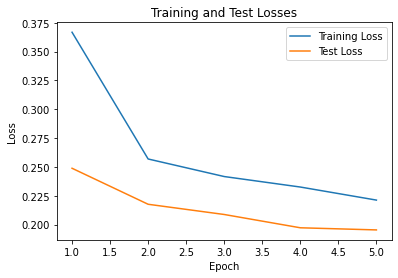

In [26]:
# Plot the training and test losses
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

# Fine-tuning original NIH on VIT fine-tuned on dataverse

In [2]:
# NIH CHEST X-RAY

image_folder_path = './nih/images'
# Load the metadata file
train_val_split = 0.2
dataset = datasets.load_dataset(
    "imagefolder",
    data_dir=image_folder_path,
)
# Split the dataset into train and validation sets
split = dataset["train"].train_test_split(train_val_split, seed=42)
train_dataset = split["train"]
test_dataset = split["test"]

Resolving data files:   0%|          | 0/5607 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/imagefolder/default-ba6a4b2ff51c7d7e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/ec2-user/.local/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


In [4]:
# Feature extraction for train dataset

train_features = []
train_labels = []
for example in train_dataset:
    image = example["image"]
    image = image.convert("RGB")
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    train_features.append(features)
    train_labels.append(example["labels"])


train_features = torch.cat(train_features, dim=0)
train_labels = torch.tensor(train_labels)

In [5]:
# Feature extraction for the test dataset
test_features = []
test_labels = []
for example in test_dataset:
    image = example["image"]
    image = image.convert("RGB")
    encoded_inputs = extractor(images=image, return_tensors="pt")
    features = encoded_inputs["pixel_values"]
    test_features.append(features)
    test_labels.append(example["labels"])

test_features = torch.cat(test_features, dim=0)
test_labels = torch.tensor(test_labels)

In [9]:
# Create DataLoader for training

train_dataset = TensorDataset(test_features, test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_features, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training Loop

In [12]:
# Initialize lists to store metrics over 10 runs
average_train_losses = []
average_test_losses = []
average_accuracies = []
average_f1_scores = []
average_auc_rocs = []

for run in range(10):  # Perform 10 runs
    train_losses = []
    test_losses = []
    accuracies = []
    f1_scores = []
    auc_rocs = []

    # Load pretrained ViT model
    vit_dir = './'
    model = ViTForImageClassification.from_pretrained(vit_dir, ignore_mismatched_sizes=True)

    # Modify the output layer for multilabel classification
    model.classifier = nn.Linear(model.config.hidden_size, NUM_CLASSES)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Move the model and data to GPU if available
    model.to(device)
    
    print(f"Run : {run+1}")

    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        # Set the model to training mode
        model.train()
        for batch_features, batch_labels in train_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)

            # Calculate loss
            loss = loss_fn(outputs.logits, batch_labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        # Calculate average training loss for the epoch
        epoch_train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(epoch_train_loss)

        # Calculate validation loss
        running_test_loss = 0.0
        true_labels = []
        predicted_labels = []
        # Set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for batch_features, batch_labels in test_dataloader:
                batch_features = batch_features.to(device)
                batch_labels = batch_labels.to(device)

                # Forward pass
                outputs = model(batch_features)
                logits = outputs.logits
                # Calculate loss
                loss = loss_fn(logits, batch_labels)
                running_test_loss += loss.item()
                # Convert logits to probabilities using sigmoid activation
                probabilities = torch.sigmoid(logits)

                # Append true labels and predicted probabilities for the batch to the lists
                true_labels.extend(batch_labels.cpu().numpy())
                predicted_labels.extend(probabilities.cpu().numpy())


        # Calculate average test loss for the epoch
        epoch_test_loss = running_test_loss / len(test_dataloader)
        test_losses.append(epoch_test_loss)

        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

        # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

        # Calculate accuracy
        predicted_labels_binary = (predicted_labels > 0.5).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels_binary)

        # Calculate AUC-ROC for each label separately
        auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

        # Calculate F1-Score (micro-averaged)
        f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

        print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score: {f1:.4f}")

    # At the end of each run, append metrics to the respective lists
    average_train_losses.append(train_losses)
    average_test_losses.append(testlosses)
    average_accuracies.append(test_accuracy)
    average_f1_scores.append(f1)
    average_auc_rocs.append(test_auc_roc)


# Calculate the average and standard deviation for each metric
avg_train_loss = np.mean(average_train_losses)
std_train_loss = np.std(average_train_losses)
avg_test_loss = np.mean(average_test_losses)
std_test_loss = np.std(average_test_losses)
avg_accuracy = np.mean(average_accuracies)
std_accuracy = np.std(average_accuracies)
avg_f1_score = np.mean(average_f1_scores)
std_f1_score = np.std(average_f1_scores)
avg_auc_roc = np.mean(average_auc_rocs)
std_auc_roc = np.std(average_auc_rocs)

# Print the average and standard deviation values
print(f"Average Train Loss: {avg_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Test Loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f} ± {std_f1_score:.4f}")
print(f"Average AUC ROC: {avg_auc_roc:.4f} ± {std_auc_roc:.4f}")   

Epoch 1/5, Train Loss: 0.4160, Test Loss: 0.3386
Test Loss: 0.3386, Test Accuracy: 0.5241, Test AUC ROC: 0.6098, F1-Score : 0.4800
Epoch 2/5, Train Loss: 0.3080, Test Loss: 0.2809
Test Loss: 0.2809, Test Accuracy: 0.2148, Test AUC ROC: 0.7135, F1-Score : 0.2812
Epoch 3/5, Train Loss: 0.2587, Test Loss: 0.2505
Test Loss: 0.2505, Test Accuracy: 0.1462, Test AUC ROC: 0.7124, F1-Score : 0.2060
Epoch 4/5, Train Loss: 0.2389, Test Loss: 0.2280
Test Loss: 0.2280, Test Accuracy: 0.2228, Test AUC ROC: 0.7385, F1-Score : 0.2964
Epoch 5/5, Train Loss: 0.2217, Test Loss: 0.2149
Test Loss: 0.2149, Test Accuracy: 0.2906, Test AUC ROC: 0.7567, F1-Score : 0.3686


In [ ]:
# Convert the main_list to a NumPy array for efficient calculations
trainlosses_array = np.array(average_train_losses)
testlosses_array = np.array(average_test_losses)

# Calculate the average along the first axis (axis=0) to get the average of each element position
train_avg_across_runs = np.mean(trainlosses_array, axis=0)
test_avg_across_runs = np.mean(testlosses_array, axis=0)

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot train losses
plt.plot(epochs, train_avg_across_runs, label='Train Loss')
# Plot test losses
plt.plot(epochs, test_avg_across_runs, label='Test Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Test Losses')
plt.legend()  # Show legend

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
# Lists to store training and test losses during each epoch
train_losses = []
test_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    # Set the model to training mode
    model.train()
    for batch_features, batch_labels in train_dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)

        # Calculate loss
        loss = loss_fn(outputs.logits, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)

    # Calculate validation loss
    running_test_loss = 0.0
    true_labels = []
    predicted_labels = []
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in test_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)
            logits = outputs.logits
            # Calculate loss
            loss = loss_fn(logits, batch_labels)
            running_test_loss += loss.item()
            # Convert logits to probabilities using sigmoid activation
            probabilities = torch.sigmoid(logits)

            # Append true labels and predicted probabilities for the batch to the lists
            true_labels.extend(batch_labels.cpu().numpy())
            predicted_labels.extend(probabilities.cpu().numpy())


    # Calculate average test loss for the epoch
    epoch_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    predicted_labels_binary = (predicted_labels > 0.5).astype(int)
    accuracy = accuracy_score(true_labels, predicted_labels_binary)

    # Calculate AUC-ROC for each label separately
    auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

    # Calculate F1-Score (micro-averaged)
    f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score : {f1:.4f}")

# Save the fine-tuned model
#model.save_pretrained(output_dir)

In [13]:
from sklearn.metrics import precision_score, recall_score
test_precision = precision_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
test_recall = recall_score(true_labels, predicted_labels_binary, average='micro')  # You can choose 'micro', 'macro', 'weighted', or 'samples'
print(test_precision)
print(test_recall)

0.8624338624338624
0.23436376707404744


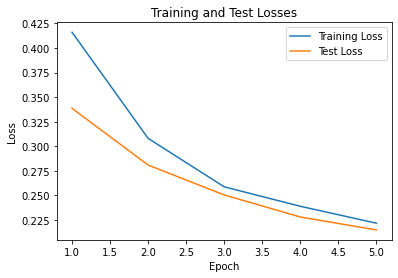

In [14]:
# Plot the training and test losses
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

In [15]:
# Save model
model_dir = './final_model_ftd_nihOG'
model.save_pretrained(model_dir)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
# Lists to store training and test losses during each epoch
train_losses = []
test_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    running_train_loss = 0.0
    # Set the model to training mode
    model.train()
    for batch_features, batch_labels in train_dataloader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_features)

        # Calculate loss
        loss = loss_fn(outputs.logits, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)

    # Calculate validation loss
    running_test_loss = 0.0
    true_labels = []
    predicted_labels = []
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_features, batch_labels in test_dataloader:
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_features)
            logits = outputs.logits
            # Calculate loss
            loss = loss_fn(logits, batch_labels)
            running_test_loss += loss.item()
            # Convert logits to probabilities using sigmoid activation
            probabilities = torch.sigmoid(logits)

            # Append true labels and predicted probabilities for the batch to the lists
            true_labels.extend(batch_labels.cpu().numpy())
            predicted_labels.extend(probabilities.cpu().numpy())


    # Calculate average test loss for the epoch
    epoch_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {NUM_EPOCHS+epoch + 1}/{NUM_EPOCHS+5}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Convert true labels and predicted labels to numpy arrays for scikit-learn metrics
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    predicted_labels_binary = (predicted_labels > 0.5).astype(int)
    accuracy = accuracy_score(true_labels, predicted_labels_binary)

    # Calculate AUC-ROC for each label separately
    auc_roc = roc_auc_score(true_labels, predicted_labels, average='macro', multi_class='ovr')

    # Calculate F1-Score (micro-averaged)
    f1 = f1_score(true_labels, predicted_labels_binary, average='micro')

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}, Test AUC ROC: {auc_roc:.4f}, F1-Score : {f1:.4f}")


In [9]:
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# Load and preprocess data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Extract features from the dataset
train_features = []
train_labels = []
for example in train_dataset:
    image = example["image"]
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension for single image
    train_features.append(image)
    train_labels.append(example["labels"])

# Convert features and labels to tensors
train_features = torch.cat(train_features, dim=0)
train_labels = torch.tensor(train_labels)

train_dataset_cnn = TensorDataset(train_features, train_labels)
train_loader = DataLoader(train_dataset_cnn, batch_size=32, shuffle=True)

# Extract features from the dataset
test_features = []
test_labels = []
for example in test_dataset:
    image = example["image"]
    image = image.convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension for single image
    test_features.append(image)
    test_labels.append(example["labels"])

# Convert features and labels to tensors
test_features = torch.cat(test_features, dim=0)
test_labels = torch.tensor(test_labels)

test_dataset_cnn = TensorDataset(test_features, test_labels)
test_loader = DataLoader(test_dataset_cnn, batch_size=32, shuffle=True)

In [16]:
ls

Untitled.ipynb   dataverse/           pytorch_model.bin  vit_train.ipynb
Untitled1.ipynb  images.zip           untitled.py
config.json      mobilenet_model.pth  unzip_script.py
data.zip         nih/                 vit_nih.ipynb


In [15]:
# Load the saved model
import torchvision.models as models

# Define the number of classes in your target domain
num_classes_target = len(train_labels[0])

# Create a new instance of the MobileNetV2 model
loaded_model = models.mobilenet_v2(pretrained=False)

# Modify the classifier layer to match the number of classes in the target domain
loaded_model.classifier[-1] = nn.Linear(1280, num_classes_target)

# Load the saved model's parameters
model_filename = 'mobilenet_model.pth'
loaded_model.load_state_dict(torch.load(model_filename), ignore_mismatch=True)

print("Model loaded successfully")

TypeError: load_state_dict() got an unexpected keyword argument 'ignore_mismatch'

In [ ]:
import torchvision.models as models
import torch.optim as optim

# Load the pretrained MobileNetV2 model
#model = models.mobilenet_v2(pretrained=True)

# Modify the last fully connected layer for your classification task
num_classes = 14
#in_features = model.classifier[-1].in_features
#model.classifier[-1] = torch.nn.Linear(in_features, num_classes)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
lr_scheduler_step = 3
lr_scheduler_gamma = 0.5

# Define optimizer and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)

# Move model and data to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
criterion.to(device)
